# MAC0318 Introdução à Programação de Robôs Móveis

## Planejamento de rotas

Nessa atividade, vamos usar técnicas de busca heurística em grafo para resolver o problema de encontra uma rota ótima. Um problema de planejamento é definido matematicamente por:
- Um conjunto de estados $S$
- Um estado inicial $s_0 \in S$
- Um estado meta $s_m \in S$
- Um conjunto de ações $A$
- Uma função $A: S \rightarrow 2^A$, que associa a cada estado um conjunto de ações aplicáveis $A(s)$ em um estado $s$
- Uma função de transição $T: S \times A \rightarrow S$, que representa a transição de estado $T(s,a)$ causada por uma ação $a$ a partir de um estado $s$
- Uma função de custo $C: S \times A \rightarrow \mathbb{R}$, que associa um custo a uma transição.

Note que o custo pode ser negativo, de fato representando uma recompensa. O objetivo do problema é encontrar uma sequência de ações aplicáveis $a_1, a_2, \ldots, a_H$ tal que levem do estado inicial ao estado meta como mínimo custo. A sequência de ações produz uma trajetória
$$
  s_1 = T(s_0, a_1), \, s_2 = T(s_1, a_2), \, \ldots, \, s_H = T(s_{H-1}, a_H) ,
$$
para a qual $a_t \in A(s_{t-1})$ para todo $t=1,\ldots,H$. Por definição, uma solução para o problema requer que $H$ seja finito, que $s_H = s_m$ e que
$$
  C(s_0, a_1) + C(s_1, a_2) + \dotsb + C(s_{H-1}, a_H)
$$
seja minímo sobre todas as sequências de ações aplicáveis que levem ao estado meta.

Equivalentemente, o problema pode ser formulado como encontrar o caminho mais curto em um multigrafo $G$ com vértices $V$, arestas $A$ e pesos $C: A \rightarrow \mathbb{R}$ sobre as aretas. Note que em um multigrafo pode haver mais de uma aresta entre dois nós, portanto $A$ é um multiconjunto.

## Grade de ocupação


Vamos usar como domínio um mapa representado como **grade de ocupação**, isto é, uma matriz de 0s e 1s com 0 indicando uma célula ocupável (ou seja, que o agente pode ocupar) e 1 indicando uma célula ocupada (ou seja, que o agente _não_ pode ocupar). Vamos assumir uma 4-vizinhança: o agente pode se deslocar para a células ocupáveis acima, à direita, à esquerda e abaixo, como mostra a figura abaixo.

<figure style="text-align: center">
    <img src="img/four-neighborhood.png" width="300">
</figure>

O ambiente será portanto representado como um grafo planar no qual os nós representam células e as aretas representam ações de locomoção. Vamos gerar um mundo aleatório assumindo que cada célula é ocupada independentemente com uma dada probabilidade. Vamos assumir que o agente inicia sempre na célula central em $(\lfloor largura/2 \rfloor, \lfloor altura/2 \rfloor)$, e que portanto é sempre desocupada. Os custos de todas as ações serão unitários.

O problema de planejamento de rota nesse mundo é encontrar um caminho do nó incial a um nó meta desejado com o menor comprimento.

In [379]:
# Importe as bibliotecas necessárias

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from collections import deque
import heapq

In [79]:
# Vamos definir uma estrutura de dados para representar um estado (uma célula)
@dataclass(frozen = True)
class State:
    x: int
    y: int

In [468]:
# A classe abaixo representa o problema de planejamento no mundo de grade de ocupação
class World:
    width: int
    height: int
    density: float
    grid: np.ndarray
    initial_state: State
    
    def __init__(self, width: int, height: int, density: float, message=True):
        self.grid = np.random.rand(height, width) < density
        self.width = width
        self.height = height
        self.initial_state = State(width//2, height//2)
        self.grid[height//2,width//2] = False
        if message:
            print("World has", self.grid.size-self.grid.sum(), "occupable cells.")
        
    def actions(self, state: State):
        ''' Returns applicable actions at given `state`. '''
        valid_actions = []
        if state.x > 0 and not self.grid[state.y,state.x-1]:
            valid_actions.append("left")
        if state.x < world.width - 1 and not self.grid[state.y,state.x+1]:
            valid_actions.append("right")
        if state.y > 0 and not self.grid[state.y-1,state.x]:
            valid_actions.append("up")
        if state.y < world.height - 1 and not self.grid[state.y+1,state.x]:
            valid_actions.append("down")
        return valid_actions
    
    def next_state(self, state: State, action: str):
        ''' Returns the successor state when applying the given `action` in given `state`. 
            Assumes `action` is applicable at `state`. '''
        if action == "left":
            return State(state.x-1, state.y)
        elif action == "right":
            return State(state.x+1, state.y)
        elif action == "up":
            return State(state.x, state.y-1)
        elif action == "down":
            return State(state.x, state.y+1)
        
    def cost(self, state: State, action: str):
        ''' Returns cost of taking `action` in given `state`. '''
        return 1.0
        
    def show(self, plan=None):
        ''' Shows world and initial state. If plan is given, also displays trajectory. '''
        M = 1-self.grid.astype(np.float32)
        M[self.initial_state.y,self.initial_state.x] = 0.5
        if plan is not None:
            for state in plan:
                M[state.y,state.x] = 0.5
        plt.imshow(M, cmap='gray');        
            



In [424]:
# Criamos um mundo aleatório com as dimensões dadas (largura, altura, densidade de ocupação)
world = World(40,10,0.25)

World has 289 occupable cells.


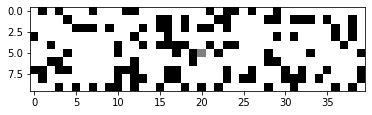

In [425]:
# Visualizamos o mundo obtido -- células pretas são ocupadas, brancas são livres, cinza marca posição inicial
world.show()

In [426]:
# Estado inicial
world.initial_state

State(x=20, y=5)

In [427]:
# Ações aplicáveis no estado inicial
world.actions(world.initial_state)

['right', 'up', 'down']

In [428]:
# Ações aplicáveis no estado (x=0, y=0)
world.actions(State(0,0))

['down']

In [429]:
# Transição do estado inicial aplicando ação "ir para a direita"
world.next_state(world.initial_state, "right")

State(x=21, y=5)

In [430]:
# Custo da ação
world.cost(world.initial_state, "right")

1.0

## Busca em profundidade

A busca em profundidade consiste em explorar um caminho até que não haja mais ações aplicáveis, e então retornar ao estado anterior. Ela é implementada mantendo-se uma pilha de estados como fronteira e selectionando sempre um estado de maior altura na fronteira (distância do camimho do mais curto ao estado inicial). Memorizar os estados visitados torna a busca completa, evitando ciclos de visitas.

In [414]:
# Busca em profundidade com memória
def depth_first_search(world: World, goal_state: State):
    if goal_state.x >= world.width or goal_state.y >= world.height or goal_state.x < 0 or goal_state.y < 0:
        print("Invalid goal state", goal_state)
        return None, np.Inf, 0
    frontier = [world.initial_state]
    path_cost = {world.initial_state: 0.0}
    backtrack = {}
    num_visited_states = 0
    while frontier:
        state = frontier.pop()
        num_visited_states += 1
        if state == goal_state:
            # Found goal state, retrieve path
            total_cost = path_cost[state]
            plan = []
            while state != world.initial_state:
                plan.append(state)
                state = backtrack[state]
            plan.append(state)                
            return plan, total_cost, num_visited_states
        for action in world.actions(state):
            next_state = world.next_state(state, action)
            if next_state not in path_cost: # Avoids cycles
                path_cost[next_state] = path_cost[state] + world.cost(state, action)
                frontier.append(next_state)
                backtrack[next_state] = state
    return None, np.Inf, num_visited_states

In [440]:
# Goal state
goal = State(0,0)

# Find plan
plan, cost, n_states = depth_first_search(world, goal)
if plan is None:
    print("Planning Failed! No possible plan exists.")
else:
    print("Found plan of cost", cost, "visiting", n_states, "states.")

Found plan of cost 89.0 visiting 128 states.


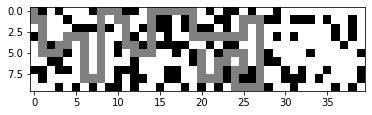

In [441]:
# Display world and plan trajectory (in gray)
world.show(plan)

---

## 💡Sua vez

Antes de prosseguir, procure se familiarizar com o algoritmo da busca em profundidade. Rode o algoritmo com mundos diferentes, obtidos alterando a densidade de células ocupadas (use valores como 0.1 e 0.5). Use metas atingíveis e inatingíveis e veja os resultados, notando o número de estados visitados. Com o mundo fixo, procure encontrar o estao meta que leva ao pior caso para a busca em número de estados visitados.

---

## Busca em largura

A busca em largura visita todos os nós a uma certa altura antes dos estados de altura estritamente maior. Ela é implementada mantendo-se uma fila de estados como fronteira e selecionando um nó de mínima altura na fronteira. A busca não requer memorização de estados para ser completa.

In [435]:
# Busca em largura com memória
def breadth_first_search(world: World, goal_state: State):
    if goal_state.x >= world.width or goal_state.y >= world.height or goal_state.x < 0 or goal_state.y < 0:
        print("Invalid goal state", goal_state)
        return None, np.Inf, 0
    frontier = deque([world.initial_state])
    path_cost = {world.initial_state: 0.0}
    backtrack = {}
    num_visited_states = 0
    while frontier:
        state = frontier.popleft()
        num_visited_states += 1
        if state == goal_state:
            # Found goal state, retrieve path
            total_cost = path_cost[state]
            plan = []
            while state != world.initial_state:
                plan.append(state)
                state = backtrack[state]
            plan.append(state)                
            return plan, total_cost, num_visited_states
        for action in world.actions(state):
            next_state = world.next_state(state, action)
            if next_state not in path_cost: # Avoids cycles
                path_cost[next_state] = path_cost[state] + world.cost(state, action)
                frontier.append(next_state)
                backtrack[next_state] = state
    return None, np.Inf, num_visited_states

In [439]:
# Goal state
goal = State(0,0)

# Find plan
plan, cost, n_states = breadth_first_search(world, goal)
if plan is None:
    print("Planning Failed! No possible plan exists.")
else:
    print("Found plan of cost", cost, "visiting", n_states, "states.")

Found plan of cost 29.0 visiting 281 states.


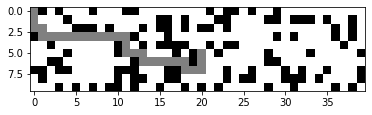

In [437]:
# Display world and plan trajectory (in gray)
world.show(plan)

---

## 💡Sua vez

Procure se familiarizar com o algoritmo da busca em largura. Rode o algoritmo com mundos diferentes, com metas atingíveis e inatingíveis e veja os resultados. Compare os custos e número de nós visitados entre as buscas em largura e em profundidade para um mesmo problema. 

---

## Busca informanda

A busca A* visita os nós seguindo uma função combinada entre o custo e uma heurística admissível, que subestima o custo restante de uma estado à meta. A busca não requer memorização de estados para ser completa ou ótima, mas a memorização aumenta a eficiência.

In [389]:
# Vamos representar as transições na busca do caminho pela seguinte estrutura de dados
@dataclass(order=True)
class PrioritizedState:
    priority: float
    count: int # to break ties
    state: State

In [452]:
L = [5,0,10]
#heapq.heapify(L)
L = []
heapq.heappush(L, PrioritizedState(5, 1, State(10,10)))
heapq.heappush(L, PrioritizedState(5, 2, State(1,10)))
heapq.heappush(L, PrioritizedState(10, 0, State(10,10)))
L

heapq.heappop(L)

PrioritizedState(priority=5, count=1, state=State(x=10, y=10))

### Heurística

Precisamos informar uma heurística $h(s)$ obedecendo as seguintes propriedades:
- $h(s) \geq 0$
- $h(m) = 0$ para o estado meta $m$
- $h(s) \leq C(s,m)$, com $C(s,m)$ indicando o menor custo do caminho de $s$ a $m$

In [438]:
def heuristic(state: State, goal_state: State):
    ''' Computes Manhattan distance from state to goal_state). '''
    return abs(state.x-goal_state.x) + abs(state.y-goal_state.y)

In [443]:
# Qual a heurística para o estado inicial -- compare com solução ótima encontrada pela busca em largura (deve ser menor)
heuristic(world.initial_state, goal)

25

In [453]:
# Busca A* com memória
def a_star_search(world: World, goal_state: State):
    if goal_state.x >= world.width or goal_state.y >= world.height or goal_state.x < 0 or goal_state.y < 0:
        print("Invalid goal state", goal_state)
        return None, np.Inf, 0
    frontier = [PrioritizedState(heuristic(world.initial_state, goal_state), 0, world.initial_state)]
    path_cost = {world.initial_state: 0.0}
    backtrack = {}
    num_visited_states = 0
    counter = 0
    while frontier:
        pstate = heapq.heappop(frontier) # remove state with least priority f(n) = cost(n) + heuristic(n)
        state = pstate.state
        num_visited_states += 1
        if state == goal_state:
            # Found goal state, retrieve path
            total_cost = path_cost[state]
            plan = []
            while state != world.initial_state:
                plan.append(state)
                state = backtrack[state]
            plan.append(state)                
            return plan, total_cost, num_visited_states
        for action in world.actions(state):
            next_state = world.next_state(state, action)
            cost = path_cost[state] + world.cost(state, action)            
            if (next_state not in path_cost) or (cost < path_cost[next_state]): # Avoids suboptimal paths
                path_cost[next_state] = cost
                f = cost + heuristic(next_state, goal_state)
                counter += 1
                heapq.heappush(frontier, PrioritizedState(f, counter, next_state) )
                backtrack[next_state] = state
    return None, np.Inf, num_visited_states

In [454]:
# Goal state
goal = State(0,0)

# Find plan
plan, cost, n_states = a_star_search(world, goal)
if plan is None:
    print("Planning Failed! No possible plan exists.")
else:
    print("Found plan of cost", cost, "visiting", n_states, "states.")

Found plan of cost 29.0 visiting 91 states.


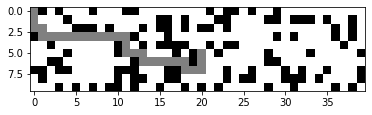

In [455]:
# Display world and plan trajectory (in gray)
world.show(plan)

## Comparação

Vamos comparar as buscas com relação à qualidade da solução encontrada (custo) e a eficiência (número de estados visitados).

In [489]:
avg_cost_A = 0.0
avg_cost_D = 0.0
avg_it_A = 0
avg_it_B = 0
avg_it_D = 0

N = 0
for i in range(100):
    myworld = World(50,10,0.1,False);
    mygoal = None
    for x in range(50):
        for y in range(10):
            if not myworld.grid[y,x]:
                mygoal = State(x,y)
                break
        if mygoal is not None:
            break
    plan_A, cost_A, n_states_A = a_star_search(myworld, mygoal)
    plan_B, cost_B, n_states_B = breadth_first_search(myworld, mygoal)
    plan_D, cost_D, n_states_D = depth_first_search(myworld, mygoal)
    
    if cost_A != cost_B: # This should never be true!
        print("Oh, Oh! Something went wrong...")
        print(f"A-star: {cost_A}  {n_states_A}")
        print(f"BFS: {cost_B}  {n_states_B}")    
        break
        
    if cost_A < np.inf: # Discard unsolvable problems
        N += 1
        avg_cost_A += cost_A
        avg_cost_D += cost_D
        avg_it_A += n_states_A
        avg_it_B += n_states_B
        avg_it_D += n_states_D

print("A-star\n  - Average Cost:", f"{avg_cost_A/N:.2f}", "\n  - Average Num. Iterations:", f"{avg_it_A/N:.2f}")
print("BFS\n  - Average Cost:", f"{avg_cost_A/N:.2f}", "\n  - Average Num. Iterations:", f"{avg_it_B/N:.2f}")
print("DFS\n  - Average Cost:", f"{avg_cost_D/N:.2f}", "\n  - Average Num. Iterations:", f"{avg_it_D/N:.2f}")



A-star
  - Average Cost: 30.08 
  - Average Num. Iterations: 110.07
BFS
  - Average Cost: 30.08 
  - Average Num. Iterations: 358.12
DFS
  - Average Cost: 118.55 
  - Average Num. Iterations: 235.23


---

## 💡Sua vez

Desenha um mundo (a matriz da grade de ocupação) que maximize o desempenho da busca A* em comparação com as outras buscas. Reflita sobre as razões das ineficiências da busca não informada para pensar em uma grade de ocupação favorável para o A*. Depois, inverta o pensamento e desenhe uma matriz na qual A* desempenha de maneira similar à busca em largura e potencialmente pior que a busca em profundidade. Você espera encontrar situações assim em problemas de planejamento de rotas?

---